# FLUX.1-dev with Diffuse: Modular Sampling Framework

This notebook demonstrates how to use FLUX.1-dev {cite}`flux2024` with the **Diffuse** sampling framework - showcasing how a modular sampling framework can help understand, investigate and experiment with sota pre-trained models.

A lot of exciting diffusion research isn't about training models - it's about the **algorithms built on top**:

- 🎨 **Image editing** (InstructPix2Pix, DiffEdit, Imagic)
- 🖼️ **Inpainting & outpainting** (RePaint, Blended Diffusion)
- 🔍 **Inverse problems** (DPS, RED-diff, medical imaging)
- 🎯 **Controllable generation** (ControlNet-style, regional control)
- 📐 **Novel sampling methods** (better integrators, adaptive schedules)
- 🧠 **Bayesian Experimental Design** (adaptive sampling for inverse problems)

All of these need **modular sampling infrastructure** to test, iterate and experiment with each component separately. Because it is hard to change different components of the pipeline (the integrator, the discretization schedule or the conditionning) most researchers tend to stick to one setting only for their experiments.

**Diffuse solves this**: Load pre-trained models → Choose your components → Assess the impact of each component on your research.

## What We'll Explore

1. **Flow Matching Models** - Understanding FLUX as a velocity field predictor
2. **Modular Components** - Swap timers, integrators, guidance without touching model code
3. **Quality Comparisons** - Visual side-by-side across configurations

## What is FLUX.1-dev?

**FLUX.1-dev** {cite}`flux2024` is a state-of-the-art text-to-image model trained using **flow matching** {cite}`Liu2022` {cite}`Lipman2022` (also called rectified flow). Unlike traditional diffusion models that learn to denoise images, FLUX learns a **velocity field** that transforms noise into images along straight paths.

### Flow Matching Background

As detailed in the [Diffusion Crash Course](diffusion_crash_course.rst), flow matching uses the straight-line interpolation path:

$$
x_t = (1-t)x_0 + t\varepsilon, \quad \varepsilon\sim\mathcal{N}(0,I), \quad t \in [0, 1]
$$

where $x_0$ is clean data and $\varepsilon$ is Gaussian noise. FLUX {cite}`flux2024` learns a **velocity field** $v_\theta(x_t, t, c)$ conditioned on text embeddings $c$ that defines the flow ODE (see Eq. {eq}`eq:flow_ode` in the crash course):

$$
\frac{dx}{dt} = v_\theta(x_t, t, c)
$$


In this context, Diffuse allows you to:
- ✅ **Swap integrators** (Euler, Heun, DPM++, DDIM) without retraining
- ✅ **Change discretization schedules** (uniform, adaptive, learned)
- ✅ **Add stochasticity** (churning, noise injection) for diversity
- ✅ **Apply to inverse problems** (inpainting, super-resolution, deblurring)
- ✅ **Compose guidance methods** (classifier-free)


**Diffuse** makes this modular and easy. Just load weights and experiment with sampling.

## Setup

In [ ]:
from pathlib import Path

import jax
import matplotlib.pyplot as plt
import numpy as np
from huggingface_hub import snapshot_download

# Download diffuse if not already installed
# !uv pip install git+https://github.com/jcopo/diffuse.git

# Diffuse components
from diffuse.denoisers.denoiser import Denoiser
from diffuse.diffusion.sde import Flow

# FLUX components
from diffuse.examples.flux_dev.run_flux_inference import (
    FluxConditionedNetwork,
    FluxModelLoader,
    _latent_shapes,
)
from diffuse.examples.flux_dev.utils import FluxTimer
from diffuse.integrator.deterministic import (
    DDIMIntegrator,
    DPMpp2sIntegrator,
    EulerIntegrator,
    HeunIntegrator,
)
from diffuse.predictor import Predictor
from diffuse.timer.base import VpTimer

print(f"JAX devices: {jax.devices()}")

JAX devices: [CudaDevice(id=0)]


## Configuration

Set the HuggingFace repo and generation parameters. The tutorial downloads the FLUX jax checkpoint from `jcopo/flux_jax` automatically, so no manual path configuration is required.


In [2]:
# HuggingFace model source
HF_REPO_ID = "jcopo/flux_jax"

CHECKPOINT_DIR = Path(
    snapshot_download(
        repo_id=HF_REPO_ID,
        repo_type="model",
    )
)
print(f"Using checkpoint from: {CHECKPOINT_DIR}")

# Generation parameters
PROMPT = "A serene landscape with mountains at sunset, highly detailed, photorealistic"
HEIGHT = 512
WIDTH = 512
NUM_STEPS = 20
GUIDANCE_SCALE = 4.0
SEED = 42

print(f"Prompt: {PROMPT}")
print(f"Resolution: {WIDTH}x{HEIGHT}")
print(f"Steps: {NUM_STEPS}")

Using checkpoint from: /linkhome/rech/genini01/upd68za/.cache/huggingface/hub/models--jcopo--flux_jax/snapshots/2421c1312395408de2fdd391fe5c0bb616363c6f
Prompt: A serene landscape with mountains at sunset, highly detailed, photorealistic
Resolution: 512x512
Steps: 20


## Load FLUX Model

This section demonstrates Diffuse's **separation of concerns** - one of the key design principles that enables rapid experimentation.

### The Three Stages

1. **Model Loading** - `FluxModelLoader` handles checkpoints, tokenizers, text encoders  
2. **Text Conditioning** - `prepare_conditioned_network` encodes prompt, returns conditioned velocity field  
3. **Sampling** - Modular components (Timer, Integrator, Denoiser) handle generation

### What does `prepare_conditioned_network` do?

FLUX was trained using flow matching to predict **velocity fields**. This function:

- **Tokenizes your prompt** using CLIP and T5 tokenizers  
- **Encodes text** through CLIP (pooled embeddings) and T5 (sequence embeddings)
- **Loads the FLUX transformer** onto GPU
- **Returns a conditioned velocity field** `v(x_t, t, c)` - a function mapping (latents + time + prompt) → velocities

Think of it as "baking" your text prompt into the velocity field. Now you can sample from this field using **any integrator** without touching text encoders again.

### This is quite interesting for Research:

- ✅ **Text encoders offloaded** after encoding (saves memory)
- ✅ **Clean velocity field interface** for sampling experiments
- ✅ **Swap sampling components** without re-encoding  
- ✅ **Zero loading complexity** for your research code


In [3]:
# Load model
loader = FluxModelLoader(checkpoint_dir=CHECKPOINT_DIR, verbose=True)

# Prepare conditioned velocity field
conditioned = loader.prepare_conditioned_network(
    prompt=PROMPT,
    negative_prompt=None,
    guidance_scale=GUIDANCE_SCALE,
    height=HEIGHT,
    width=WIDTH,
)

print(f"\nConditioned network ready (dtype={conditioned.dtype})")

[flux-loader] Host CPU device: cpu:0
[flux-loader] Active compute device: gpu:0
[flux-loader] Preparing conditioned network
[flux-loader] Encoding 1 prompt(s)
[flux-loader] Tokenizing prompts for CLIP/T5
[flux-loader] Restoring clip_text on gpu:0
[flux-loader] Loaded clip_text parameters (~234.72MB)
[flux-loader] CLIP pooled embedding shape (1, 768), dtype=bfloat16
[flux-loader] Restoring t5_text on gpu:0
[flux-loader] Loaded t5_text parameters (~8.87GB)
[flux-loader] T5 hidden state shape (1, 512, 4096), dtype=bfloat16
[flux-loader] Releasing text encoders
[flux-loader] Releasing clip_text from gpu:0
[flux-loader] Releasing t5_text from gpu:0
[flux-loader] Restoring transformer on gpu:0
[flux-loader] Loaded transformer parameters (~22.17GB)

Conditioned network ready (dtype=bfloat16)


## Helper Functions: Modular Sampling with Diffuse

The key to Diffuse's power is **separation of concerns**. Each component has **one job**:

- **Timer**: Decides WHEN to evaluate the model (discretization schedule)
- **Predictor**: Wraps the velocity field `v(x_t, t)` from FLUX so that it can be evaluated as both velocity, score or noise
- **Integrator**: Decides HOW to step from `x_t` to `x_{t-1}` (numerical ODE solver)
- **Denoiser**: Orchestrates the full sampling loop

This modularity is the entire point: **change one component, everything else stays the same**.

Want to test a new integrator idea? Just swap one line.  
Want to try a different schedule? Just swap one line.  
Want to add guidance? Just swap the Denoiser.


In [4]:
def run_generation(
    conditioned_network: FluxConditionedNetwork,
    timer,
    integrator_class,
    num_steps: int,
    seed: int,
) -> jax.Array:
    """Generate image using modular Diffuse components."""
    # Modular component assembly
    flow = Flow(tf=1.0)
    predictor = Predictor(
        model=flow,
        network=conditioned_network.network_fn,
        prediction_type="velocity",
    )
    integrator = integrator_class(model=flow, timer=timer)
    denoiser = Denoiser(
        integrator=integrator,
        model=flow,
        predictor=predictor,
        x0_shape=(transformer_hw[0], transformer_hw[1], conditioned_network.in_channels),
    )

    # Run sampling
    key = jax.random.PRNGKey(seed)
    state, _ = denoiser.generate(
        rng_key=key,
        n_steps=num_steps,
        n_particles=1,
        keep_history=False,
    )
    return state.integrator_state.position

In [5]:
def decode_and_display(latents: jax.Array, loader: FluxModelLoader) -> np.ndarray:
    """Decode latents to RGB image."""
    images = loader.decode_latents(latents)
    return images[0]


def plot_comparison(images: dict, title: str, figsize=(15, 10)):
    """Plot grid of images for comparison."""
    n = len(images)
    cols = min(3, n)
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()

    for idx, (name, img) in enumerate(images.items()):
        axes[idx].imshow(img)
        axes[idx].set_title(name, fontsize=12, fontweight="bold")
        axes[idx].axis("off")

    for idx in range(len(images), len(axes)):
        axes[idx].axis("off")

    plt.suptitle(title, fontsize=16, fontweight="bold", y=0.98)
    plt.tight_layout()
    plt.show()

## Part 1: Timer Comparison

Timers control the **time discretization** $t \in [0, 1]$. Different schedules allocate more steps to different noise levels.

### VpTimer
Linear discretization: $t_i = t_f + \frac{i}{N}(\epsilon - t_f)$

### FluxTimer
Applies a Möbius transformation to bias sampling toward low-noise regions:

$$
\sigma_{\text{shifted}}(t) = \frac{\mu \cdot \sigma(t)}{1 + (\mu - 1) \cdot \sigma(t)}
$$

- **Static mode**: Fixed $\mu = 1.15$ (FLUX default)
- **Dynamic mode**: Resolution-adaptive $\mu(L)$ based on sequence length $L$

The Möbius shift allocates more steps to fine details (low noise), improving quality.

In [6]:
# Create timers
vp_timer = VpTimer(n_steps=NUM_STEPS, eps=1e-3, tf=1.0)
flux_timer_static = FluxTimer(n_steps=NUM_STEPS, eps=1e-3, tf=1.0, shift=1.15, use_dynamic_shift=False)
flux_timer_dynamic = FluxTimer(n_steps=NUM_STEPS, eps=1e-3, tf=1.0, shift=1.15, use_dynamic_shift=True)
_, transformer_hw = _latent_shapes(HEIGHT, WIDTH)
image_seq_len = transformer_hw[0] * transformer_hw[1]
flux_timer_dynamic.set_image_seq_len(image_seq_len)

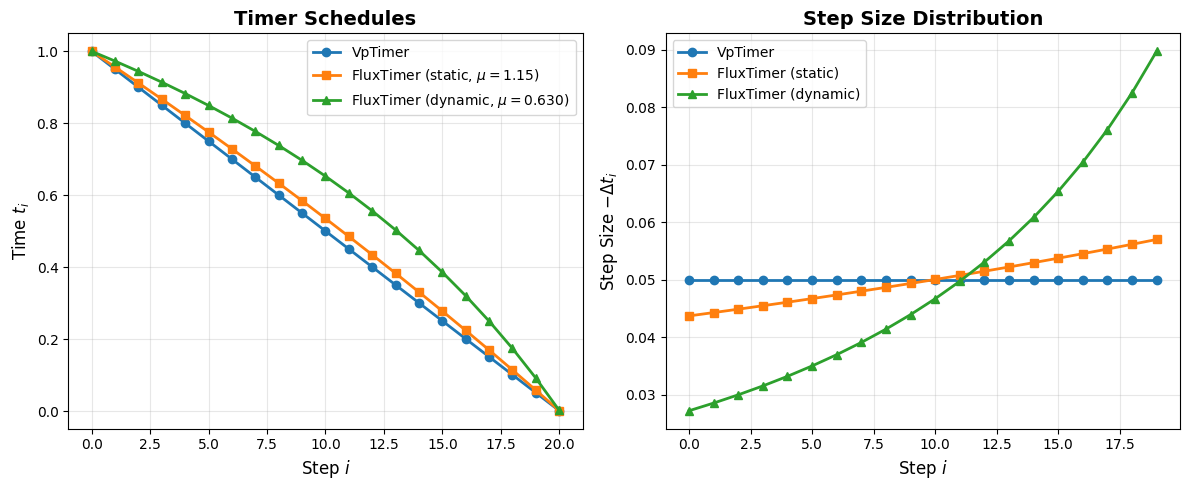


Resolution: 512x512 → 1024 tokens
Dynamic shift μ: 0.630


In [7]:
# Visualize schedules
steps = np.arange(NUM_STEPS + 1)
vp_schedule = [vp_timer(s) for s in steps]
flux_static_schedule = [flux_timer_static(s) for s in steps]
flux_dynamic_schedule = [flux_timer_dynamic(s) for s in steps]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(steps, vp_schedule, "o-", label="VpTimer", linewidth=2)
plt.plot(steps, flux_static_schedule, "s-", label=r"FluxTimer (static, $\mu=1.15$)", linewidth=2)
plt.plot(steps, flux_dynamic_schedule, "^-", label=f"FluxTimer (dynamic, $\\mu={flux_timer_dynamic._mu:.3f}$)", linewidth=2)
plt.xlabel("Step $i$", fontsize=12)
plt.ylabel("Time $t_i$", fontsize=12)
plt.title("Timer Schedules", fontsize=14, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
diff_static = np.diff(flux_static_schedule)
diff_dynamic = np.diff(flux_dynamic_schedule)
diff_vp = np.diff(vp_schedule)
plt.plot(steps[:-1], -diff_vp, "o-", label="VpTimer", linewidth=2)
plt.plot(steps[:-1], -diff_static, "s-", label="FluxTimer (static)", linewidth=2)
plt.plot(steps[:-1], -diff_dynamic, "^-", label="FluxTimer (dynamic)", linewidth=2)
plt.xlabel("Step $i$", fontsize=12)
plt.ylabel("Step Size $-\\Delta t_i$", fontsize=12)
plt.title("Step Size Distribution", fontsize=14, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nResolution: {WIDTH}x{HEIGHT} → {image_seq_len} tokens")
print(f"Dynamic shift μ: {flux_timer_dynamic._mu:.3f}")

### Generate with Different Timers

We use `DDIMIntegrator` {cite}`Song2020b` (see crash course section on DDIM) to isolate the effect of the timer.

Generating with VpTimer...
[flux-loader] Decoding latents through VAE
[flux-loader] Restoring vae on gpu:0
[flux-loader] Loaded vae parameters (~319.75MB)
[flux-loader] Releasing VAE
[flux-loader] Releasing vae from gpu:0
Generating with FluxTimer (static)...
[flux-loader] Decoding latents through VAE
[flux-loader] Restoring vae on gpu:0
[flux-loader] Loaded vae parameters (~319.75MB)
[flux-loader] Releasing VAE
[flux-loader] Releasing vae from gpu:0
Generating with FluxTimer (dynamic)...
[flux-loader] Decoding latents through VAE
[flux-loader] Restoring vae on gpu:0
[flux-loader] Loaded vae parameters (~319.75MB)
[flux-loader] Releasing VAE
[flux-loader] Releasing vae from gpu:0


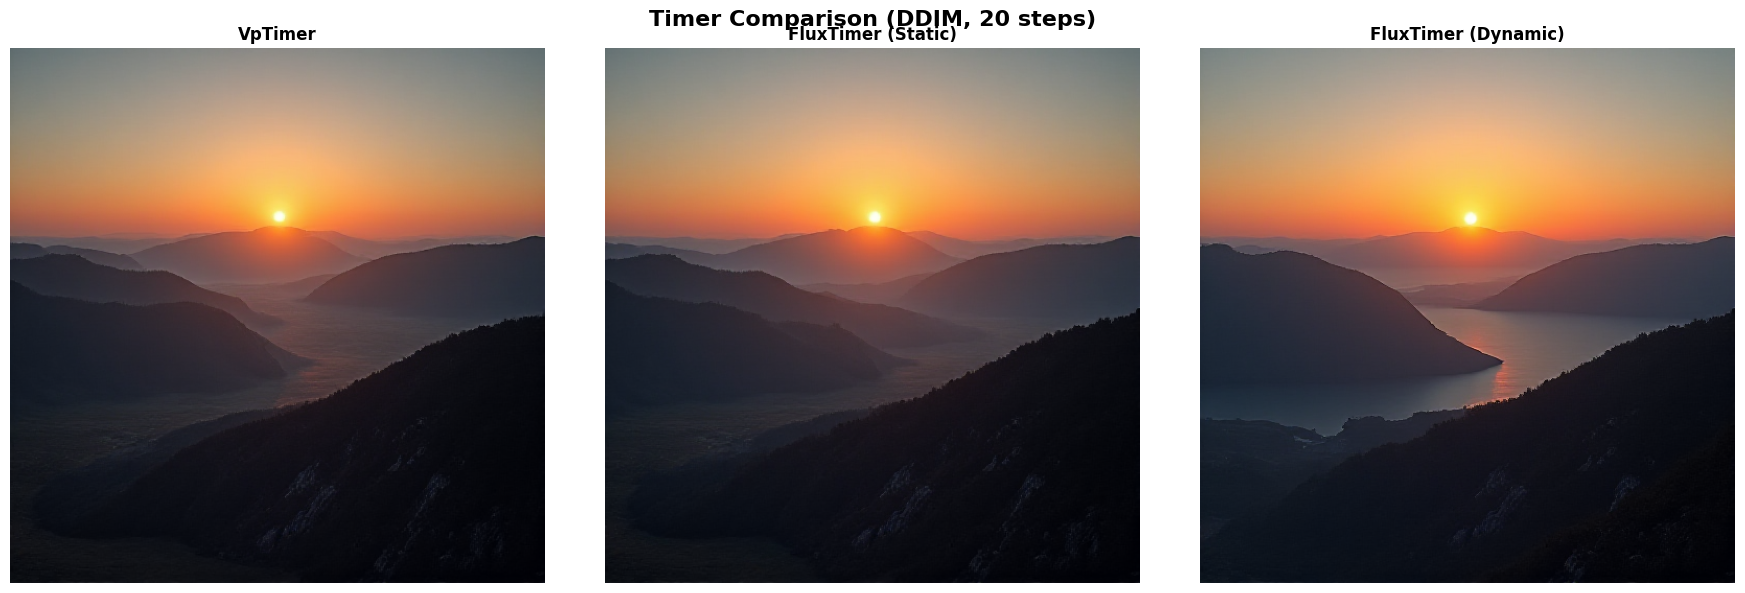

In [15]:
print("Generating with VpTimer...")
latents_vp = run_generation(conditioned, vp_timer, DDIMIntegrator, NUM_STEPS, SEED)
img_vp = decode_and_display(latents_vp, loader)

print("Generating with FluxTimer (static)...")
latents_flux_static = run_generation(conditioned, flux_timer_static, DDIMIntegrator, NUM_STEPS, SEED)
img_flux_static = decode_and_display(latents_flux_static, loader)

print("Generating with FluxTimer (dynamic)...")
latents_flux_dynamic = run_generation(conditioned, flux_timer_dynamic, DDIMIntegrator, NUM_STEPS, SEED)
img_flux_dynamic = decode_and_display(latents_flux_dynamic, loader)

timer_images = {
    "VpTimer": img_vp,
    "FluxTimer (Static)": img_flux_static,
    "FluxTimer (Dynamic)": img_flux_dynamic,
}

plot_comparison(
    timer_images,
    f"Timer Comparison (DDIM, {NUM_STEPS} steps)",
    figsize=(18, 6),
)

**Expected Differences:**
- **VpTimer**: Uniform steps, may miss fine details
- **FluxTimer (Static)**: More low-noise steps, better details
- **FluxTimer (Dynamic)**: Adapts to the resolution of the image, see the finer details in the lake

## Part 2: Integrator Comparison

### What Are Integrators?

FLUX gives us a velocity field `v(x_t, t)` - it tells us "which direction to move" at each point. An **integrator** is the numerical method we use to follow that velocity field from noise (t=1) to image (t=0). It is defined by an `Integrator` class that implements how to go from `x_t` to `x_{t-1}`.

### Why Integrators Matter for Quality

Different integrators can significantly affect **visual quality**. For example:
- DPM++2S often produces **sharper reflections** (like sunlight on water)
- Heun preserves **fine texture details** better than Euler


### Integrators We'll Compare

**DDIM** {cite}`Song2020b` (see crash course section on DDIM)
- Fast, deterministic, well-tested
- Good default choice for most applications

**Euler** (First-Order)
- Simplest: just follow the velocity directly
- Fast but can accumulate errors over many steps  
- Good for quick previews

**Heun** (Second-Order)
- "Look ahead" method: predicts next step, corrects itself
- 2x slower (two model evaluations per step) but more accurate
- Better detail preservation

**DPM++2S** {cite}`Lu2022` (Second-Order Optimized)
- Like Heun but with optimized stability
- Often produces best quality 


### Key Insight: Quality vs Speed Trade-off

- **Same steps**: Heun ≈ DPM++2S > DDIM > Euler (quality)
- **Same compute**: DDIM at 40 steps ≈ Heun at 20 steps
- **For FLUX**: DPM++2S often produces noticeably better fine details

Let's see the visual differences using FluxTimer. Diffuse allows you to test different integrators with the same code, with minimal friction in code changes:

In [9]:
# Use FluxTimer for fair comparison
timer_for_comparison = FluxTimer(n_steps=NUM_STEPS, eps=1e-3, tf=1.0, shift=1.15, use_dynamic_shift=False)

integrators = [
    ("DDIM", DDIMIntegrator),
    ("Euler", EulerIntegrator),
    ("Heun", HeunIntegrator),
    ("DPM++2S", DPMpp2sIntegrator),
]

integrator_images = {}

for name, integrator_class in integrators:
    print(f"Generating with {name}...")
    latents = run_generation(conditioned, timer_for_comparison, integrator_class, NUM_STEPS, SEED)
    img = decode_and_display(latents, loader)
    integrator_images[name] = img

Generating with DDIM...
[flux-loader] Decoding latents through VAE
[flux-loader] Restoring vae on gpu:0
[flux-loader] Loaded vae parameters (~319.75MB)
[flux-loader] Releasing VAE
[flux-loader] Releasing vae from gpu:0
Generating with Euler...
[flux-loader] Decoding latents through VAE
[flux-loader] Restoring vae on gpu:0
[flux-loader] Loaded vae parameters (~319.75MB)
[flux-loader] Releasing VAE
[flux-loader] Releasing vae from gpu:0
Generating with Heun...
[flux-loader] Decoding latents through VAE
[flux-loader] Restoring vae on gpu:0
[flux-loader] Loaded vae parameters (~319.75MB)
[flux-loader] Releasing VAE
[flux-loader] Releasing vae from gpu:0
Generating with DPM++2S...
[flux-loader] Decoding latents through VAE
[flux-loader] Restoring vae on gpu:0
[flux-loader] Loaded vae parameters (~319.75MB)
[flux-loader] Releasing VAE
[flux-loader] Releasing vae from gpu:0


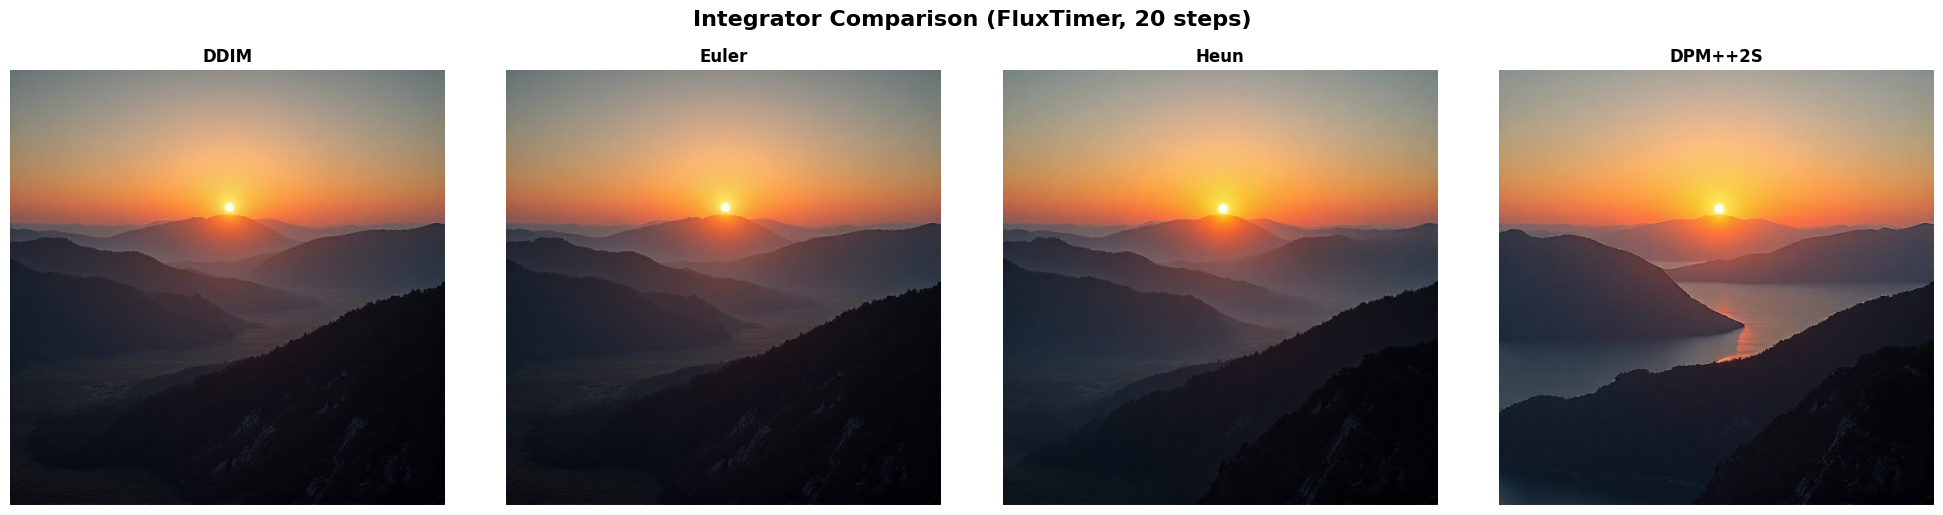

In [10]:
# Show all integrators in one row
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, (name, img) in zip(axes, integrator_images.items()):
    ax.imshow(img)
    ax.set_title(name, fontsize=12, fontweight="bold")
    ax.axis("off")

plt.suptitle(f"Integrator Comparison (FluxTimer, {NUM_STEPS} steps)", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

### Integrator Detail Zooms

To highlight subtle differences, we also compare **center crops** from each integrator output. This makes sheen, edge contrast, and texture preservation easier to inspect.


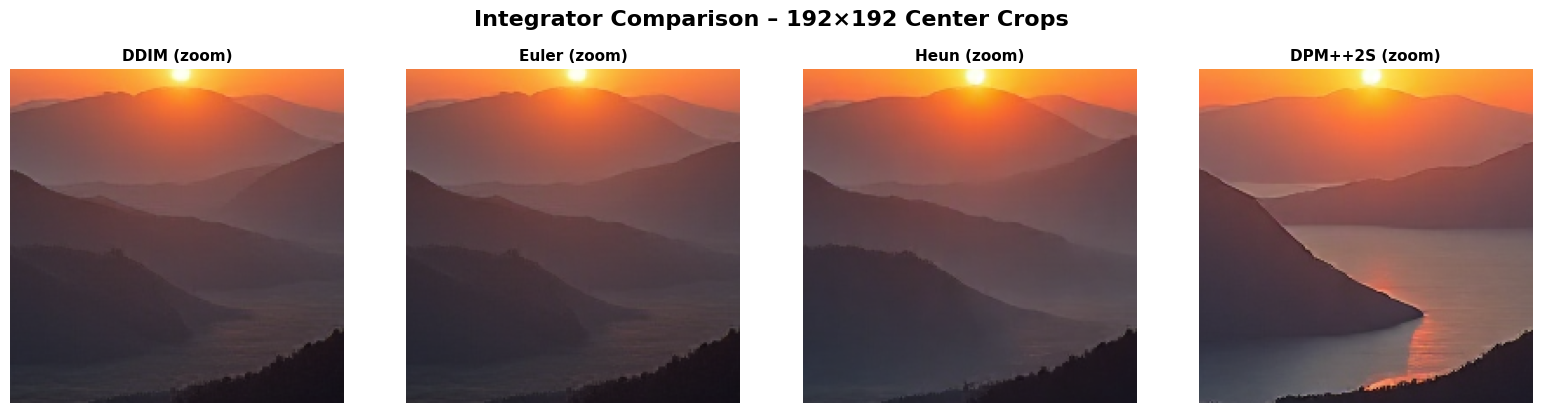

In [11]:
CROP_SIZE = 192


def crop_center(img, size=CROP_SIZE):
    h, w, _ = img.shape
    top = (h - size) // 2
    left = (w - size) // 2
    return img[top : top + size, left : left + size]


zoom_crops = {name: crop_center(img) for name, img in integrator_images.items()}

# Show all crops in one row
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, (name, crop) in zip(axes, zoom_crops.items()):
    ax.imshow(crop)
    ax.set_title(f"{name} (zoom)", fontsize=11, fontweight="bold")
    ax.axis("off")

plt.suptitle("Integrator Comparison – 192×192 Center Crops", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

## Part 3: Batched Generation Benchmark

Because `.generate()` is JAX-powered, specifying `n_particles` enables us to draw many samples in parallel (10 in this example). JAX handles this efficiently by using `vmap` under the hood to maximize GPU utilization.

In [ ]:
import time

NUM_BENCHMARK_SAMPLES = 10
benchmark_seed = SEED + 1234

flow = Flow(tf=1.0)
predictor = Predictor(
    model=flow,
    network=conditioned.network_fn,
    prediction_type="velocity",
)
integrator = EulerIntegrator(model=flow, timer=flux_timer_dynamic)

benchmark_denoiser = Denoiser(
    integrator=integrator,
    model=flow,
    predictor=predictor,
    x0_shape=(
        transformer_hw[0],
        transformer_hw[1],
        conditioned.in_channels,
    ),
)

key_benchmark = jax.random.PRNGKey(benchmark_seed)
start_time = time.perf_counter()
benchmark_state, _ = benchmark_denoiser.generate(
    rng_key=key_benchmark,
    n_steps=NUM_STEPS,
    n_particles=NUM_BENCHMARK_SAMPLES,
    keep_history=False,
)

benchmark_latents = benchmark_state.integrator_state.position
benchmark_images = loader.decode_latents(benchmark_latents)
benchmark_images.block_until_ready()
generation_time = time.perf_counter() - start_time

print(f"✓ Generated {NUM_BENCHMARK_SAMPLES} samples in {generation_time:.2f}s ")

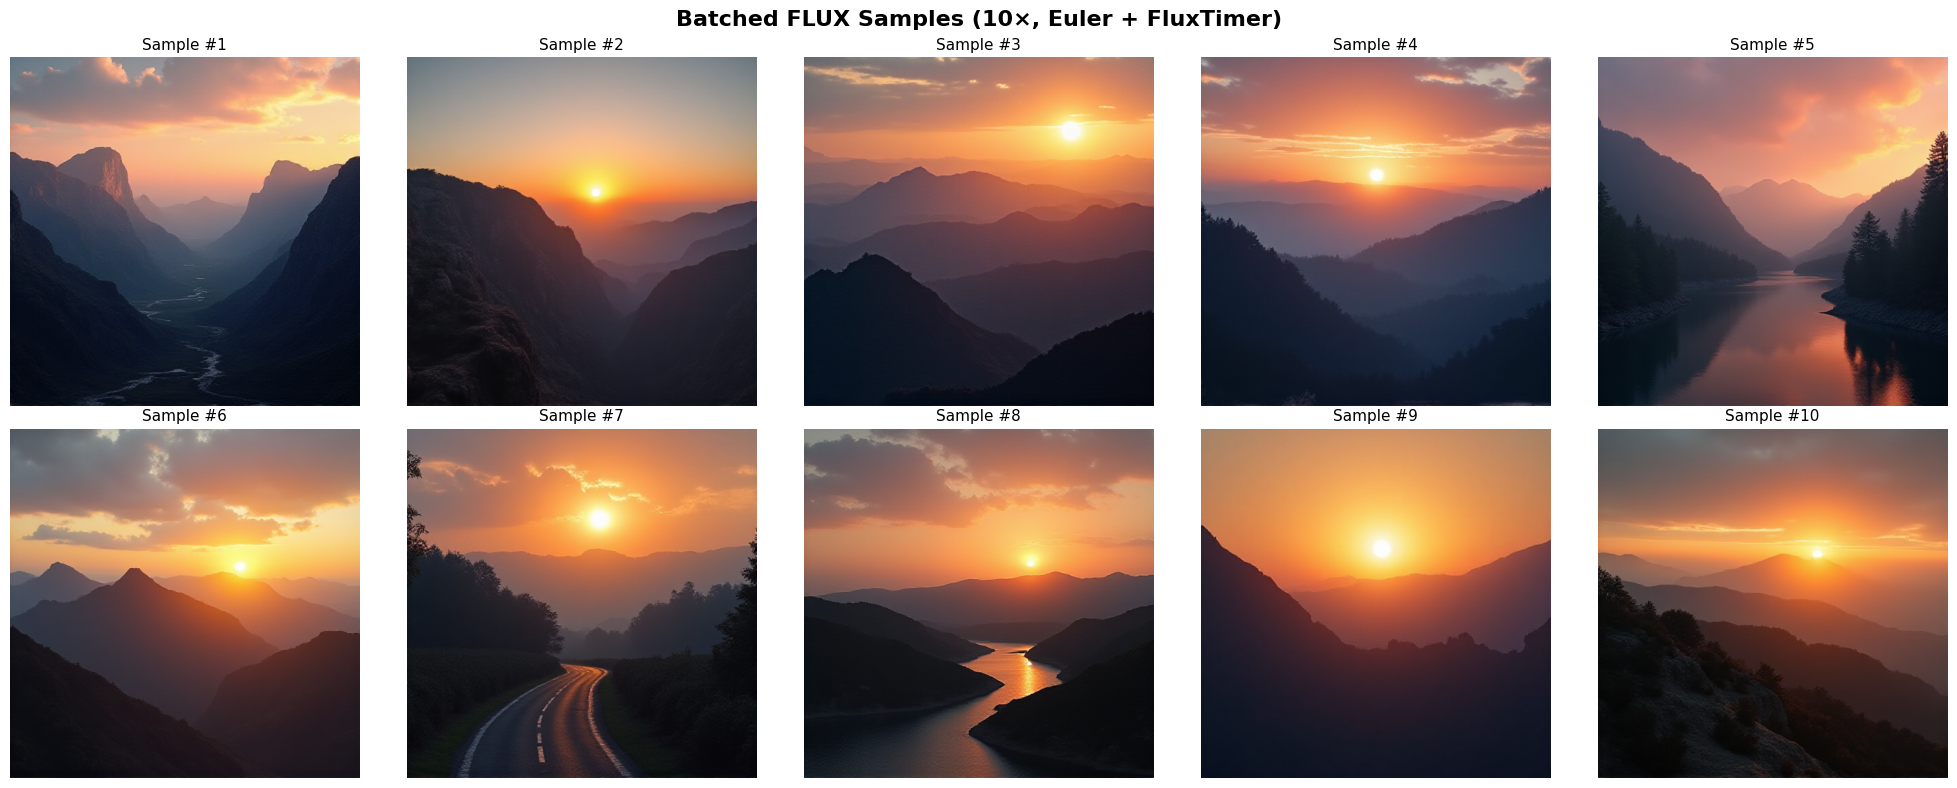

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    if idx < NUM_BENCHMARK_SAMPLES:
        ax.imshow(benchmark_images[idx])
        ax.set_title(f"Sample #{idx + 1}", fontsize=11)
        ax.axis("off")
    else:
        ax.axis("off")

plt.suptitle(
    "Batched FLUX Samples (10×, Euler + FluxTimer)",
    fontsize=16,
    fontweight="bold",
    y=0.98,
)
plt.tight_layout()
plt.show()

## Summary: The Power of Modular Sampling

An interesting direction for diffusion research lies in **algorithms built on top of pre-trained models**. Diffuse enables you to:

**Focus on research** – minimal setup overhead, intuitive pipeline  
**Build on SOTA** – seamless integration with FLUX, Stable Diffusion, and custom models  
**Prototype fast** – from idea to working code in under 50 lines

**Built for Sampling Research** This notebook demonstrates Diffuse's core philosophy: **separation of concerns enables rapid experimentation**. It provides clean protocols to implement new ideas on:

- **Novel ODE/SDE solvers** via the Integrator protocol
- **Adaptive schedules** via the Timer protocol
- **Guidance methods** by extending Denoiser
- **Inverse problems** via ForwardModel implementations

### What We Explored

1. **FLUX as Flow Matching** – velocity field prediction via continuous normalizing flows (see Eq. {eq}`eq:flow_interpolation` in the crash course)
2. **Timers** – discretization schedules including VpTimer and FluxTimer with Möbius shift
3. **Integrators** – ODE solvers (DDIM, Euler, Heun, DPM++2S)
4. **Batched Sampling** – parallel 10-sample generation





## References

```{bibliography}
:filter: docname in docnames
```